# Identifying the influence of episodic events on groundwater recharge in semi-arid environments using environmental tracers

This is the code accompanying the paper by Chmielarski et al. (in review) of the same name. The following code presents a deconvolution approach to extracting specific proportions of groundwater recharge input events. This code incorporates a spatial correlation between bores within the same lithology to provide more data for the approximation of the solution. 

Note, that this code can includes a non-negative solver after Cirpka et al. (2007), which was developed in Python by McCallum et al. (2017) along with unity weight. 

For full clarification, the analytical solution which is presented in this code can best be understood by following the supplementary documentation to the Chmielarski et al. (in review) paper, which presents a step-by-step solution.

# Import Python packages

In [1]:
import numpy as np
import scipy as sp
import numpy.linalg as la
import pylab as plt
import pandas as pd

from numpy import *
from scipy import *
from pylab import *
from scipy.optimize import minimize

# Non-negative solver function

In [2]:
def Hmake(uloc):
    nv = np.int(sum(uloc))
    ng = len(uloc)
    H = np.zeros((nv,ng))
    ct = -1
    for i in range(ng):
        if uloc[i] >0 :
            ct+=1
            H[ct,i] = 1.
    #print(H)
    return(H)

hw = 1e5
def non_neg_solve(A,b,hw = 1e5):
    dim1 = np.shape(A)
    dim2 = np.shape(b)
    if dim2[0] != dim1[1]:
        print ('INCOMPATIBLE dIMENSIONS in non_neg_solve')
        return(-999)
    
    if dim1[0] != dim1[1]:
        A = np.dot(A.T,A)
        b = np.dot(A.T,b)
    
    A_inv = np. linalg.pinv(A)
    x = np.dot(A_inv,b)
    uloc = np.zeros_like(x)
    uloc[x<0] = 1.
    if sum(uloc) == 0:
        return(x)
    
    nv = int(sum(uloc))
    itct = 0
    while True:
        ulocold = np.copy(uloc)
        itct += 1
        H = Hmake(uloc)
        AA = np.zeros((dim1[1]+nv,dim1[1]+nv))
        bb = np.zeros(dim1[1]+nv)
        AA[:dim1[1],:dim1[1]] = A
        AA[dim1[1]:,:dim1[1]] = H*hw
        AA[:dim1[1]:,dim1[1]:] = H.T*hw
        bb[:dim1[1]] = b
        try:
            AA_inv = np.linalg.pinv(AA, rcond=1e-15)
        except:
            x = np.ones(dim1[1])*-999
            print('SVD failed')
            return(x,False)
            break
        xx = np.dot(AA_inv,bb)
        x = xx[:dim1[1]]
        v = xx[dim1[1]:]
        vdum = np.ones_like(uloc)
        ct = -1
        for i in range(len(x)):
            if uloc[i] > 0.:
                ct+=1
                vdum[i] = v[ct]
        uloc[:] = 0.
        uloc[x<0] = 1.
        uloc[vdum<=0.] = 1.
        nv = int(sum(uloc))
        if sum(abs(uloc-ulocold)) == 0:
            print('model converged')
            return(x,True)
            break
        elif itct == 100:
            #x = -999
            print('failed 2 converge')
            return(x,False)
            break

# Atmospheric data input

In [3]:
#loading up the atmospheric data file
atmos=np.loadtxt("atmos_update.dat", skiprows=1)

#Defining what data you're going to use - this is from the atmos.dat sheet
#In the case of the data collected for the alluvial fan study, we only use C14, CFC11, CFC12, CFC113, and H3
#However, the atmos.dat sheet contains data for Ar-39, Kr-85, and SF6 as well
date = atmos[:,0]
C14 = atmos[:,1]
CFC11 = atmos[:,3]
CFC12 = atmos[:,4]
CFC113 = atmos[:,5]
H3 = atmos[:,7]
#putting in the decay rates of the radioactive tracers (CFCs etc. not included)
lam=np.zeros(8)
#carbon-14
lam[0] = np.log(2)/5730
#tritium
lam[6] = np.log(2)/12.46

########INPUTTING THE RECHARGE SOURCES: CYCLONES#########

#loading up the cyclone years up to 2020 (data was extracted from Rouillard et al. (2015))
cyclone = pd.read_csv("Alluvial_fan_cyclones.csv")
cyclone_input = np.array(cyclone) #the age shows the input years that we're dealing with
sample_date= 2020.7 #what year you took your sample in - on the alluvial fan we sampled close to the end of 2020
#putting together your age index, which will describe the 'events' that the model is trying to inform
AGE = []
age_index =[]
cyc_year = []
DTAU = [] #this is the lengths of input years
for i in range(len(cyclone_input)):
    if cyclone_input[i,1] > 0:
        dum = cyclone_input[i,0]
        AGE.append(sample_date-dum)
        age_index.append(np.argmin(np.abs(date-dum)))
        cyc_year.append(dum)
        DTAU.append(cyclone['dtau'][i])
DTAU = np.array(DTAU)
#flip the age index and corresponding DTAU so age is sequential
age_index = age_index[::-1]
cyc_year = cyc_year[::-1]
DTAU = DTAU[::-1]
AGE = AGE[::-1]

1911.91
1916.79
1917.87
1924.9
1927.04
1930.74
1933.96
1941.82
1944.92
1945.88
1946.95
1947.78
1953.15
1955.17
1959.82
1961.13
1966.02
1968.28
1971.14
1973.05
1975.67
1978.89
1979.85
1980.92
1984.97
1987.95
1991.0
1994.98
1996.05
1996.77
1998.8
2001.9
2002.85
2004.04
2005.95
2011.91
2013.06
2013.98
2015.19
2016.07
2017.21
2017.99
2019.21
2020.01


# 'A' matrix of atmospheric inputs

In [4]:
#number of observations is how many environmental tracers we are using (C14, CFC11, CFC12, CFC113, and H3 -> so 5)
#add an observation for the d13C results, which are used to correct the C14 for age interpretation
nobs=6.
ng=len(cyc_year) #the number for g is how long the vector g is going to be, in this case the number of events we created in "cyc_year"
matrix_params1 = (int(nobs),int(ng))
A = np.zeros(matrix_params1) #defininf the shape of the A matrix

##Filling out the A matrix, which holds all the atmospheric concentrations
#Here we fill in the matrix with the outcomes of the five tracers over the possible input events defined by Rouillard et al. (2015)
Cg=-17 #Cg can be many values, for the alluvial fan this is approximated as halfway between the mean d13C value (~13) and the max (~21)
for j in range(ng):
    tdum = np.array([DTAU[j]/2])
    for i in range(len(tdum)):
        rdate = cyc_year[j] + tdum[i]
        age_index[j] = (np.argmin(np.abs(date-rdate)))
        A[0,j]+=C14[age_index[j]]*np.exp(-(sample_date-rdate)*lam[0])*DTAU[j] #Carbon-14 inputs, including the decay over time
        A[1,j]+=Cg*DTAU[j] #the Cg value will be used for correcting the Carbon-14 results
        A[2,j]+=CFC11[age_index[j]]*np.exp(-(sample_date-rdate)*0.)*DTAU[j] #CFC-11, with no decay 
        A[3,j]+=CFC12[age_index[j]]*np.exp(-(sample_date-rdate)*0.)*DTAU[j] #CFC-12, with no decay 
        A[4,j]+=CFC113[age_index[j]]*np.exp(-(sample_date-rdate)*0.)*DTAU[j] #CFC-113, with no decay 
        A[5,j]+=H3[age_index[j]]*np.exp(-(sample_date-rdate)*lam[6])*DTAU[j] #Tritium, with the tritium decay over time

###C-14/'old water' matrix###
nobs=6
nofcbins=7 #these seven bins represent seven C-14 half-lives, accounting for the potential to sense events up to ~40,000 years ago
matrix_params2 = (nobs, nofcbins) 
historic_matrix = np.zeros(matrix_params2)
for j in range(nofcbins):
    t1 = j*5730.
    t2 = (j+1)*5730.
    if j ==0:
        t1 = 110. #this is the end of where the Rouillard et al. (2015) data informs recharge events to 
    AGE.append((t1+t2)/2.)
    historic_matrix[0,j] = -100*np.exp(-lam[0]*t2)/lam[0] + 100*np.exp(-lam[0]*t1)/lam[0]
    historic_matrix[1,j] = Cg * (t2 - t1)
    DTAU = np.append(DTAU, t2-t1)

#horizontally stack (hstack) the two matrices together so that the deconvolution can attribute recharge to both 'modern' and 'old' water bins
    #final outcome is still six rows (all are evaluated to the same CFC11, CFC12, CFC113, C-14, and tritium)
A = np.hstack((A,historic_matrix))

# 'b' vector of concentration outcomes 

In [5]:
#loading up the alluvial fan environmental tracer concentrations
##note = all N/A answers are put in as -999.00
Alluvial_fan = pd.read_csv("Alluvial_fan.csv")
aquifer_names = list(Alluvial_fan['Aquifer'].unique())
##sub-sample for aquifer
aquifer = 'Alluvium' #the options on the alluvial fan are Alluvium, BID, CID, and dolomite
AF = Alluvial_fan[Alluvial_fan.Aquifer == aquifer]
AF = AF.reset_index() #resets the index so each aquifer of interest can be used with consecutive index numbers

nsamp = len(AF)
AA = np.zeros((np.shape(A)[0]*nsamp+nsamp, np.shape(A)[1]*nsamp)) #creating the shapes for the outcome matrix (proportions of input events)
Qv = np.zeros(np.shape(A)[0]*nsamp+nsamp) #creating the shape of Qv (error) matrix
bb = np.zeros(np.shape(A)[0]*nsamp+nsamp) #bb is the 'outcome' vector - these are the values we collect in the field
ldum = [] #ldum will allow for the removal of CFCs that didn't work or do not exist
tdum=np.zeros_like(bb) #tdum will be used to split tracers for later comparison between modelled and measured values
unity_weight = 1000. #unity_weight keeps the deconvolved proportions to sum to 1, or 100% of a sample

C13dum = [] #creating a vector for d13C correction data
for i in range(nsamp):
    #creating the 'start' and 'end' keeps the outcome square, which is important for matrix inversion later
    start1 = i * (np.shape(A)[0]+1)
    end1 =  start1 + (np.shape(A)[0])
    start2 = i * np.shape(A)[1]
    end2 =  (i+1) * np.shape(A)[1]
    C13dum.append(AF['13C'][i])
    Adum = copy(A)
    AA[start1:end1,start2:end2] = Adum
    bb[start1] = AF['pMC'][i] #vector of our outcomes which were collected around the alluvial fan
    ldum.append(start1)
    #tdum gives a number to each tracer of interest, where 0 is the weighting, 1 is C-14, 2 is d13C, 3 is CFC11, 4 is CFC12, 5 is CFC113, and 6 is tritium
    tdum[start1:start1+6] = np.arange(1,7,1)
    bb[start1+1] = AF['13C'][i]   
    bb[start1+2] = AF['CFC11'][i]
    if AF['CFC11'][i] > 0.:
        ldum.append(start1+2)
        C13dum.append(-999)
    bb[start1+3] = AF['CFC12'][i]
    if AF['CFC12'][i] > 0.:
        ldum.append(start1+3)
        C13dum.append(-999)
    bb[start1+4] = AF['CFC113'][i]
    if AF['CFC113'][i] > 0.:
        ldum.append(start1+4)
        C13dum.append(-999)
    bb[start1+5] = AF['Trit'][i]
    ldum.append(start1+5)
    C13dum.append(-999)
    bb[start1+6] =  1.
    C13dum.append(-999)
    ldum.append(start1+6)    
    AA[end1,start2:end2] = DTAU
    #putting the error matrix together
    Qv[start1] = 1./AF['rand_err'][i]**2
    Qv[start1+1] = 1./AF['13C_err'][i]**2
    Qv[start1+2] = 1./AF['CFC11_err'][i]**2
    Qv[start1+3] = 1./AF['CFC12_err'][i]**2
    Qv[start1+4] = 1./AF['CFC113_err'][i]**2
    Qv[start1+5] = 1./AF['Trit_err'][i]**2
    Qv[start1+6] = unity_weight

#all things to solve are then adjusted to remove for the solution of factors that would have no data (e.g. missing CFCs) using ldum
AA = AA[ldum,:]
bb = bb[ldum]
C13dum = np.array(C13dum)
Qv = Qv[ldum]
tdum = tdum[ldum]

# 'GAMMA' matrix of spatial correlation

In [6]:
anis = 0.01 #vertical anisotropy value
GAMMA = np.zeros((nsamp,nsamp)) #shape of GAMMA
slope = 1e-5 #this is the slope that weighs the lag between two points together. This needs to be tested for each new dataset to understand how likelihood is affected
for i in range(nsamp):
    for j in range(nsamp):
        dist = np.sqrt((AF['Easting'][i]-AF['Easting'][j])**2+ #different in the x direction
                       (AF['Northing'][i]-AF['Northing'][j])**2+ #different in the y direction
                       ((AF['Depth_mAHD'][i]-AF['Depth_mAHD'][j])/anis)**2) #different in the z direction
        GAMMA[i,j] = dist*slope
GAMMAinv = np.linalg.pinv(GAMMA)  
Reg = np.zeros((nsamp*len(DTAU),nsamp*len(DTAU))) #making the shape of the regularisation matrix
for i in range(nsamp):
    for j in range(nsamp):
        start3 = i * len(DTAU)
        end3 = (i+1) * len(DTAU)
        start4 = j * len(DTAU)
        end4 = (j+1) * len(DTAU)  
        Reg[start3:end3,start4:end4] = np.identity(len(DTAU))*GAMMAinv[i,j]

# Finding the maximum likelihood solution

In [7]:
nrealz = 11 #here the number of realisations can be 11 for testing, but is put up to 1001 to find the complete maximum likelihood solution
g_all = np.zeros((nsamp,ng+7,nrealz)) #g_all will contain all the proportions of input events
converged = np.zeros(nrealz,dtype = bool)
cgmin = -17 
cgmax = -10

for i in range(nrealz):
    result = [] 
    if i == 0.:
        Cg = (cgmax+cgmin)/2.
        F= C13dum/Cg
        F[F>1.] = 1.
        Adum = np.dot(np.dot(AA.T,np.diag(Qv)),AA)
        bmod = bb/F
        bdum = np.dot(np.dot(AA.T,np.diag(Qv)),bmod)
        Adum -= Reg
        x2, cdum = non_neg_solve(Adum, bdum, hw = hw)
    else:
        cdum = False
        while cdum == False:
            bbb = np.abs(np.random.normal(bb,1./np.sqrt(Qv)))
            bbb[bb == 1.] = 1.
            Cg = cgmin + np.random.rand()*(cgmax-cgmin) 
            F= C13dum/Cg
            F[F>1.] = 1.
            bmod = bbb/F
            bdum = np.dot(np.dot(AA.T,np.diag(Qv)),bmod)
            x2, cdum = non_neg_solve(Adum, bdum,hw = hw)
    print(str(i)+"/"+str(nrealz))
    g = x2.reshape(nsamp,ng+7)
    if i ==0:
        gbest = np.copy(g) ###gbest is therefore the maximum likelihood distribution using the data available
        fbest = np.copy(F)
    for j in range(nsamp):
        g_all[j,:,i] = np.cumsum(g[j,:]*DTAU)
    modelled = np.dot(AA,x2)*F
    if i == 0:
        L = (modelled-bb)**2
        L = np.dot(Qv,L)
        L = -np.sum(L)
    converged[i] = cdum

model converged
0/11
model converged
1/11
model converged
2/11
model converged
3/11
model converged
4/11
model converged
5/11
model converged
6/11
model converged
7/11
failed 2 converge
model converged
8/11
model converged
9/11
model converged
10/11


# Summary statistics of g_all

In [8]:
print('likelihood = ', L)
lower = np.percentile(g_all,16,axis = 2)
medn = np.percentile(g_all,50,axis = 2)
upper = np.percentile(g_all,84,axis = 2)

likelihood =  -249.5567556008712


# Example figure 1 - collected versus modelled tracers

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a f

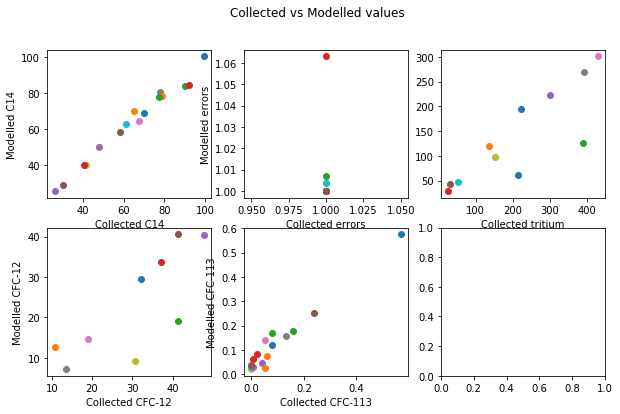

In [9]:
plt.figure(figsize=(10,6))
plt.suptitle('Collected vs Modelled values')
plt.subplot(2,3,6)
for i in range(len(modelled)):
    if tdum[i] == 1.: #C-14
        plt.subplot(2,3,1)
        plt.plot(bb[i], modelled[i], "o")
        plt.xlabel('Collected C14')
        plt.ylabel('Modelled C14')
    elif tdum[i] == 0.: #weighting
        plt.subplot(2,3,2)
        plt.plot(bb[i], modelled[i], "o")
        plt.xlabel('Collected errors')
        plt.ylabel('Modelled errors')
    elif tdum[i] == 4.: #CFC-12
        plt.subplot(2,3,3)
        plt.plot(bb[i], modelled[i], "o")
        plt.xlabel('Collected tritium')
        plt.ylabel('Modelled tritium')
    elif tdum[i] == 5.: #CFC-113
        plt.subplot(2,3,4)
        plt.plot(bb[i], modelled[i], "o")
        plt.xlabel('Collected CFC-12')
        plt.ylabel('Modelled CFC-12')
    elif tdum[i] == 6.: #Tritium
        plt.subplot(2,3,5)
        plt.plot(bb[i], modelled[i], "o")
        plt.xlabel('Collected CFC-113')
        plt.ylabel('Modelled CFC-113')
fig1name = (str(aquifer)+ '_hw' +str(hw)+ '_slope'+str(slope)+'_collmod')
plt.savefig(str(fig1name) +'.png')

# Example figure 2 - cumulative sums of ages with errors

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a

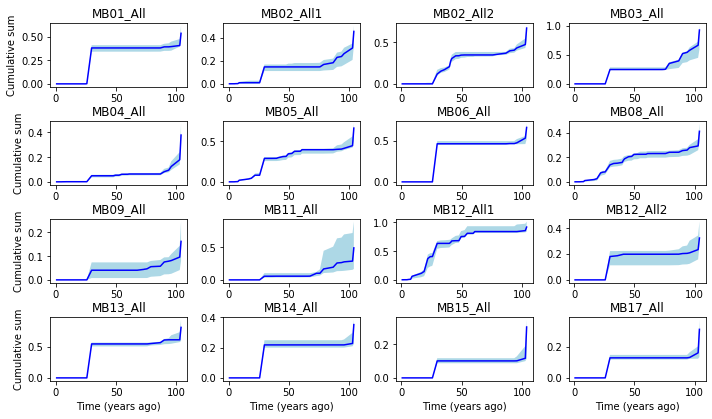

In [10]:
if aquifer == 'Alluvium':
    plt.figure(figsize=(10,6))
    for i in range(nsamp):
        plt.subplot(4,4,i+1)
        plt.plot((AGE[0:43]), medn[i,:43], 'b-')
        plt.fill_between((AGE[0:43]), lower[i,:43], upper[i,:43], facecolor='lightblue')
        plt.title(str(AF['new_Bore_ID'][i]))
        if plt.subplot(4,4,1):
            plt.ylabel('Cumulative sum')
        if plt.subplot(4,4,5):
            plt.ylabel('Cumulative sum')
        if plt.subplot(4,4,9):
            plt.ylabel('Cumulative sum')
        if plt.subplot(4,4,13):
            plt.ylabel('Cumulative sum')
            plt.xlabel('Time (years ago)')
        if plt.subplot(4,4,14):
            plt.xlabel('Time (years ago)')
        if plt.subplot(4,4,15):
            plt.xlabel('Time (years ago)')
        if plt.subplot(4,4,16):
            plt.xlabel('Time (years ago)')
        plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529) 
elif aquifer == 'CID':
    plt.figure(figsize=(10,6))
    for i in range(nsamp):
        plt.subplot(3,3,i+1)
        plt.plot((AGE[0:43]), medn[i,:43], 'b-')
        plt.fill_between((AGE[0:43]), lower[i,:43], upper[i,:43], facecolor='lightblue')
        plt.title(str(AF['new_Bore_ID'][i]))
        if plt.subplot(3,3,1):
            plt.ylabel('cumulative sum')
        if plt.subplot(3,3,4):
            plt.ylabel('cumulative sum')
        if plt.subplot(3,3,7):
            plt.ylabel('cumulative sum')
            plt.xlabel('time (years ago)')
        if plt.subplot(3,3,8):
            plt.xlabel('time (years ago)')
        if plt.subplot(3,3,9):
            plt.xlabel('time (years ago)')
        plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529)
elif aquifer == 'BID':
    plt.figure(figsize=(10,6))
    for i in range(nsamp):
        plt.subplot(2,3,i+1)
        plt.plot((AGE[0:43]), medn[i,:43], 'b-')
        plt.fill_between((AGE[0:43]), lower[i,:43], upper[i,:43], facecolor='lightblue')
        plt.title(str(AF['new_Bore_ID'][i]))
        if plt.subplot(2,3,1):
            plt.ylabel('cumulative sum')
        if plt.subplot(2,3,4):
            plt.ylabel('cumulative sum')
            plt.xlabel('time (years ago)')
        if plt.subplot(2,3,5):
            plt.xlabel('time (years ago)')
        if plt.subplot(2,3,6):
            plt.xlabel('time (years ago)')
        plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529)
elif aquifer == 'Dolomite':
    plt.figure(figsize=(10,6))
    for i in range(nsamp):
        plt.subplot(2,2,i+1)
        plt.plot((AGE[0:43]), medn[i,:43], 'b-')
        plt.fill_between((AGE[0:43]), lower[i,:43], upper[i,:43], facecolor='lightblue')
        plt.title(str(AF['new_Bore_ID'][i]))
        if plt.subplot(2,2,1):
            plt.ylabel('cumulative sum')
        if plt.subplot(2,2,3):
            plt.ylabel('cumulative sum')
            plt.xlabel('time (years ago)')
        if plt.subplot(2,2,2):
            plt.xlabel('time (years ago)')
        plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529)
fig2name = (str(aquifer)+ '_hw' +str(hw)+ '_slope'+str(slope)+'_cumsum')
plt.savefig(str(fig2name) +'.png')

# Example figure 3 - proportions of inputs from each defined event

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes 

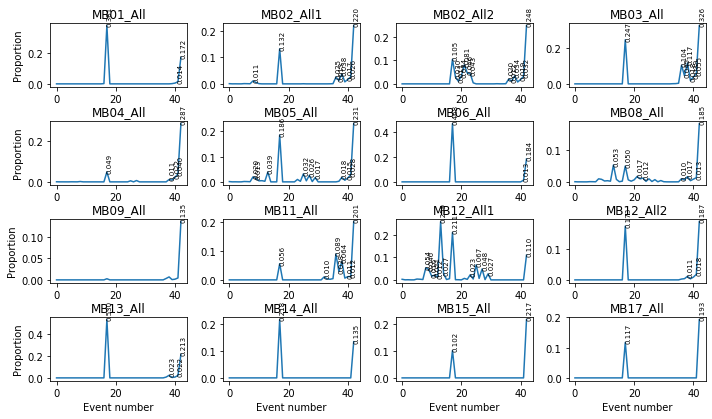

In [11]:
if aquifer == 'Alluvium':
    plt.figure(figsize=(10,6))
    for i in range(len(g)):
        plt.subplot(4,4,i+1)
        outcome = gbest[i,:43]*DTAU[0:43]
        plt.plot(outcome)
        plt.title(AF['new_Bore_ID'][i])
        for j in range(len(outcome)):
            if outcome[j] > 0.01:
                label="{:.3f}".format(outcome[j])
                plt.annotate(s=label, xy=(j, outcome[j]), fontsize=7, rotation=90)
        if plt.subplot(4,4,1):
            plt.ylabel('Proportion')
        if plt.subplot(4,4,5):
            plt.ylabel('Proportion')
        if plt.subplot(4,4,9):
            plt.ylabel('Proportion')
        if plt.subplot(4,4,13):
            plt.ylabel('Proportion')
            plt.xlabel('Event number')
        if plt.subplot(4,4,14):
            plt.xlabel('Event number')
        if plt.subplot(4,4,15):
            plt.xlabel('Event number')
        if plt.subplot(4,4,16):
            plt.xlabel('Event number')
    plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529)
elif aquifer == 'CID':
    plt.figure(figsize=(10,6))
    for i in range(len(g)):
        plt.subplot(3,3,i+1)
        outcome = gbest[i,:43]*DTAU[0:43]
        plt.plot(outcome)
        plt.title(AF['new_Bore_ID'][i])
        for j in range(len(outcome)):
            if outcome[j] > 0.01:
                label="{:.3f}".format(outcome[j])
                plt.annotate(s=label, xy=(j, outcome[j]), fontsize=7, rotation=90)
        if plt.subplot(3,3,1):
            plt.ylabel('proportion')
        if plt.subplot(3,3,4):
            plt.ylabel('proportion')
        if plt.subplot(3,3,7):
            plt.ylabel('proportion')
            plt.xlabel('bin number')
        if plt.subplot(3,3,8):
            plt.xlabel('bin number')
        if plt.subplot(3,3,9):
            plt.xlabel('bin number')
    plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529)
elif aquifer == 'BID':
    plt.figure(figsize=(10,6))
    for i in range(len(g)):
        plt.subplot(2,3,i+1)
        outcome = gbest[i,:43]*DTAU[0:43]
        plt.plot(outcome)
        plt.title(AF['new_Bore_ID'][i])
        for j in range(len(outcome)):
            if outcome[j] > 0.01:
                label="{:.3f}".format(outcome[j])
                plt.annotate(s=label, xy=(j, outcome[j]), fontsize=7, rotation=90)
        if plt.subplot(2,3,1):
            plt.ylabel('proportion')
        if plt.subplot(2,3,4):
            plt.ylabel('proportion')
            plt.xlabel('bin number')
        if plt.subplot(2,3,5):
            plt.xlabel('bin number')
        if plt.subplot(2,3,6):
            plt.xlabel('bin number')
    plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529)
elif aquifer == 'Dolomite':
    plt.figure(figsize=(10,6))
    for i in range(len(g)):
        plt.subplot(2,2,i+1)
        outcome = gbest[i,:43]*DTAU[0:43]
        plt.plot(outcome)
        plt.title(AF['new_Bore_ID'][i])
        for j in range(len(outcome)):
            if outcome[j] > 0.01:
                label="{:.3f}".format(outcome[j])
                plt.annotate(s=label, xy=(j, outcome[j]), fontsize=7, rotation=90)
        if plt.subplot(2,2,1):
            plt.ylabel('proportion')
        if plt.subplot(2,2,3):
            plt.ylabel('proportion')
            plt.xlabel('bin number')
        if plt.subplot(2,2,4):
            plt.xlabel('bin number')
    plt.subplots_adjust(left=0.058, bottom=0.101, right=0.968, top=0.930, wspace=0.263, hspace=0.529)
fig3name = (str(aquifer)+ '_hw' +str(hw)+ '_slope'+str(slope)+'_prop')
plt.savefig(str(fig3name) +'.png')

Relevant references:

Chmielarski, M., S. Dogramaci, P. Cook, G. Skrzypek, A. Jackson, M. Nelson Tredwell, and J.L. McCallum. (in review). Identifying the influence of episodic events on groundwater recharge in semi-arid environments using environmental tracers. Journal of Hydrology XXX

Cirpka, O.A., M.N. Fienen, M. Hofer, E. Hoehn, A. Tessarini, R. Kipfer, and P.K. Kitanidis. (2007). Analyzing bank filtration by deconvoluting time series of electric conductivity. Groundwater 45: 318-328.

McCallum, J.L., P.G. Cook, S. Dogramaci, R. Purtschert, C.T. Simmonds, and L. Burk (2017). Identifying modern and historic recharge events from tracer-derived groundwater age distributions. Water Resources Research 53: 1039-1056.

Rouillard, A., G. Skrzypek, S. Dogramaci, C. Turney, and P.F. Grierson. (2015). Impacts of high inter-annual variability of rainfall on a century of extreme hydrologic regime of northwest Australia. Hydrology and Earth System Sciences 19: 2057-2078.